In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
path = '/disk1/hrb/python/'

In [2]:
class calib():
    def __init__(self, obj, ID, band):
        self.obj = obj
        self.band = band
        self.ID = ID
        
    def read(self):
        self.sdss = pd.read_csv(path+'data/merged/{}/{}_band/grouped_stats_{}_sdss.csv'.format(self.obj, self.band, self.band), index_col=self.ID)
        self.ps   = pd.read_csv(path+'data/merged/{}/{}_band/grouped_stats_{}_ps.csv'  .format(self.obj, self.band, self.band), index_col=self.ID)
        self.ztf  = pd.read_csv(path+'data/merged/{}/{}_band/grouped_stats_{}_ztf.csv' .format(self.obj, self.band, self.band), index_col=self.ID)
        
    def join_colors(self):
        self.colors = pd.read_csv(path+'data/computed/{}/colors_sdss.csv'.format(self.obj), index_col=self.ID)
        self.sdss = self.sdss.join(self.colors, on=self.ID, how='left')
        self.ps   = self.ps  .join(self.colors, on=self.ID, how='left')
        self.ztf  = self.ztf .join(self.colors, on=self.ID, how='left')
        
    def calculate_offsets(self):
        offsets = self.colors
        offsets['ps-sdss_nat'] = self.ps ['mag_med_native'] - self.sdss['mag_med_native']
#         offsets['sdss-ztf_nat']= self.sdss['mag_med_native']-self.ztf['mag_med_native']
        offsets['ps-ztf_nat']  = self.ps  ['mag_med_native']-self.ztf['mag_med_native']
        
        offsets['ps-sdss'] = self.ps ['mag_med'] - self.sdss['mag_med']
#         offsets['sdss-ztf']= self.sdss['mag_med']-self.ztf['mag_med']
        offsets['ps-ztf']  = self.ps  ['mag_med']-self.ztf['mag_med']
        
        offsets['mean_mag_sdss']  = self.sdss['mag_med']
        
        self.offsets = offsets
        
    def sns_correlate(self, xname, yname, vmin, vmax, color='blue', limits=None, colorscale=None, g=None, save=False, **kwargs):
        """
        Seaborn jointplot with marginal distributions

        Parameters
        ----------
        xname : str
        yname : str
        vmin  : int
        vmax  : int
        color : str
        limits: list of tuples
        colorscale : str
        g : axis handle
        save : bool
        kwargs : dict, passed to ax.set()

        Returns
        -------
        value : type
            desc
        """
        data = self.offsets[[xname,yname]]

        # Setting up limits
        if limits is None:
            lims = lambda x, n: (x.mean()-n*x.std(), x.mean()+n*x.std())
            xbounds = lims(data[xname], 3) # set the window to +/- 3 sigma from the mean
            ybounds = lims(data[yname], 2.5)
        else:
            xbounds, ybounds = limits[0], limits[1]
        bounds={xname:xbounds, yname:ybounds}

        # Remove data outside limits
        data = data[((xbounds[0] < data[xname])&(data[xname] < xbounds[1])) & ((ybounds[0] < data[yname])&(data[yname] < ybounds[1]))]

        # Setting up colors
        marg_color = {'blue':'royalblue', 'red':'salmon'}[color]
        joint_color = {'blue':'Blues', 'red':'Reds'}[color]

        if g is None:
            g = sns.JointGrid(x=xname, y=yname, data=data, xlim=bounds[xname], ylim=bounds[yname], height=8)

        # If colorscale is 'log', use log scale and vmin, vmax as limits. Otherwise, default
        if colorscale == 'log':
            from matplotlib.colors import LogNorm
            norm = LogNorm(vmin=vmin, vmax=vmax)
            vmin=None
            vmax=None
        else:
            norm = None
        # Plot
        g = g.plot_joint(plt.hexbin, norm=norm, cmap='jet', vmin=vmin, vmax=vmax)#, gridsize=(200,200))
    #     g = sns.jointplot(x=xname, y=yname, data=data, xlim=bounds[xname], ylim=bounds[yname], height=6)
        g.ax_marg_x.hist(data[xname], bins=200, color=marg_color, alpha=0.5)
        g.ax_marg_y.hist(data[yname], bins=200, orientation='horizontal', density = True, color=marg_color, alpha=0.5)

        # Uncomment below to invert axis - needed when plotting absolute mag on y axis
    #     g.ax_joint.invert_yaxis()

        # Set axis labels and fontsize
        g.ax_joint.set_xlabel(kwargs['xlabel'], fontsize=25)
        g.ax_joint.set_ylabel(kwargs['ylabel'], fontsize=25)
        # Increase fontsize of ticks
        g.ax_joint.tick_params(axis='both', which='major', labelsize=20)
    #     g.ax_joint.set(**kwargs)

        # Uncomment below to add y=0 and x=0 dashed lines
        plt.axhline(y=0, lw=0.7, color='k', ls='--', dashes=(20,10))
    #     plt.axvline(x=0, lw=0.2, color='k', ls='--', dashes=(20,10))

        plt.grid(lw = 0.2, which='major')

        # Save
        if save:
            g.savefig(path+'analysis/plots/{}_{}_vs_{}.pdf'.format(self.obj,xname,yname), bbox_inches='tight')

        # Return axis handle
        return g

In [3]:
qsos_r = calib('qsos','uid','r')
qsos_r.read()
qsos_r.join_colors()
qsos_r.calculate_offsets()

# STARS
---

In [4]:
star_r = calib('calibStars','uid_s','r')
star_r.read()
star_r.join_colors()
star_r.calculate_offsets()

In [6]:
star_r.offsets['ps-sdss_nat'].mean()

-0.009740093435586739

In [8]:
star_r.offsets['ps-sdss'].mean()

-0.0016227453794539516

In [9]:
star_r.offsets['ps-ztf_nat'].mean()

0.1268452925921621

In [10]:
star_r.offsets['ps-ztf'].mean()

0.027018752680965662

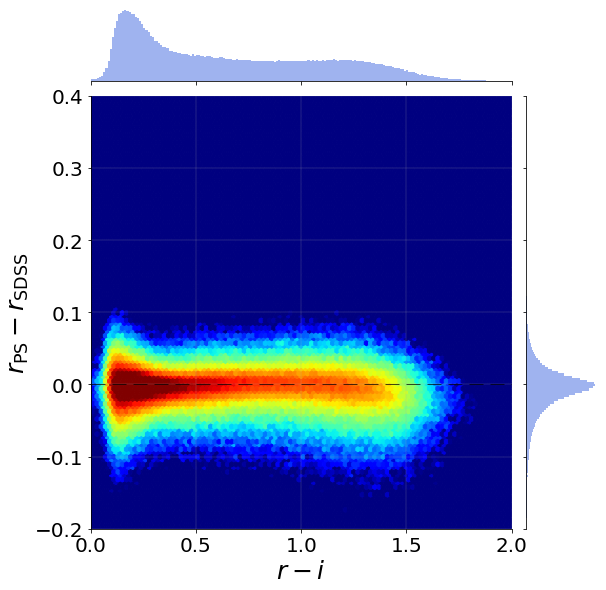

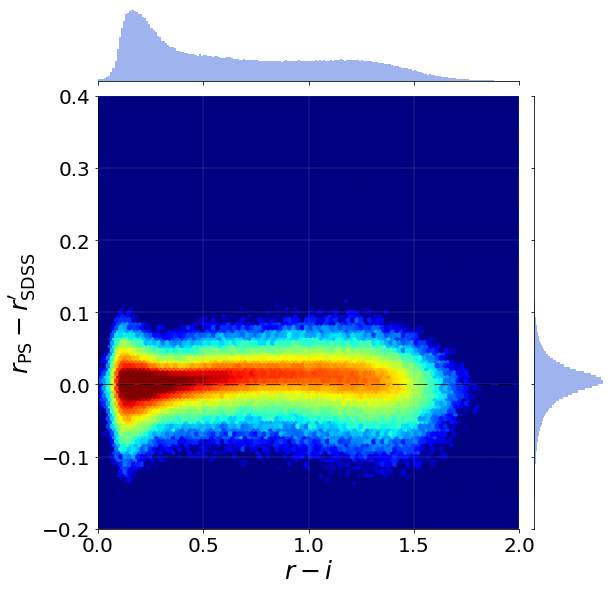

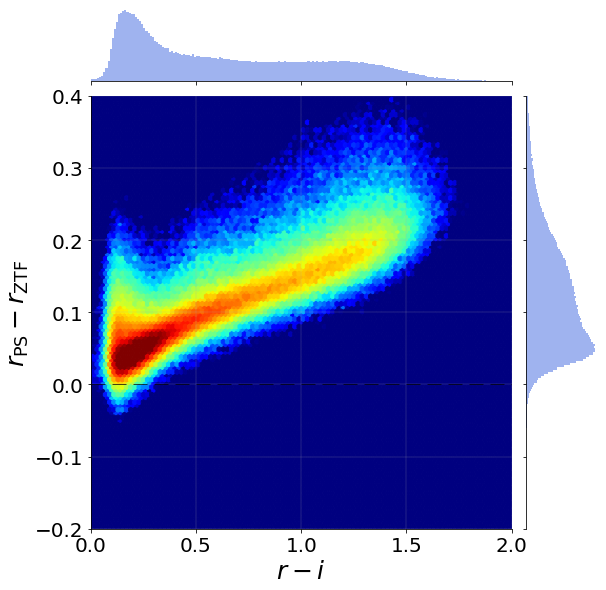

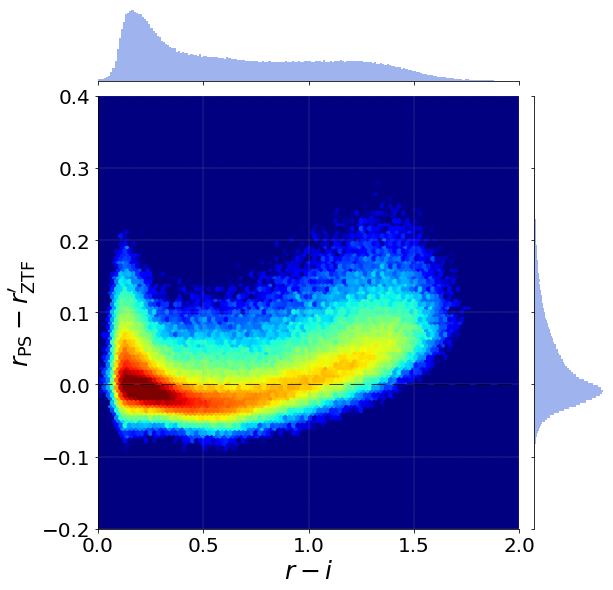

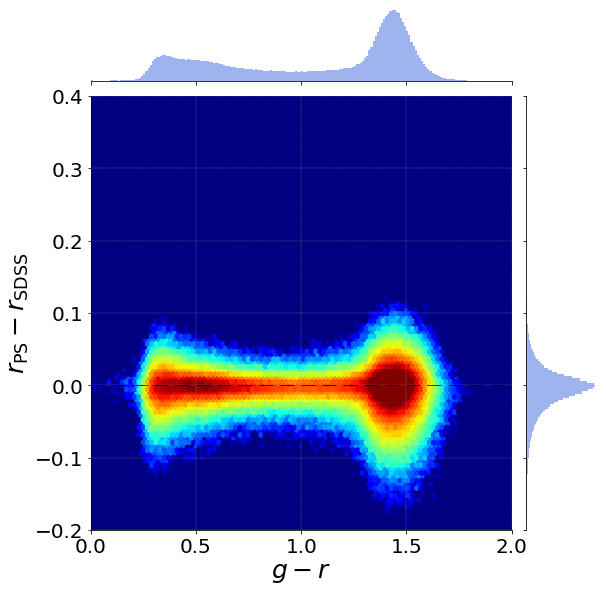

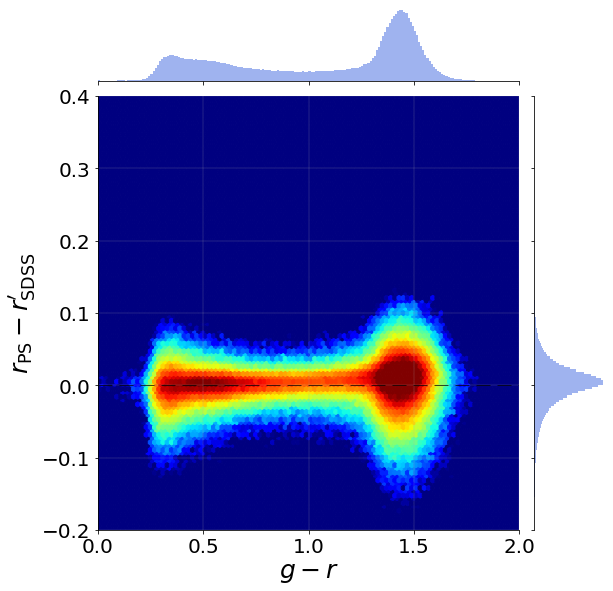

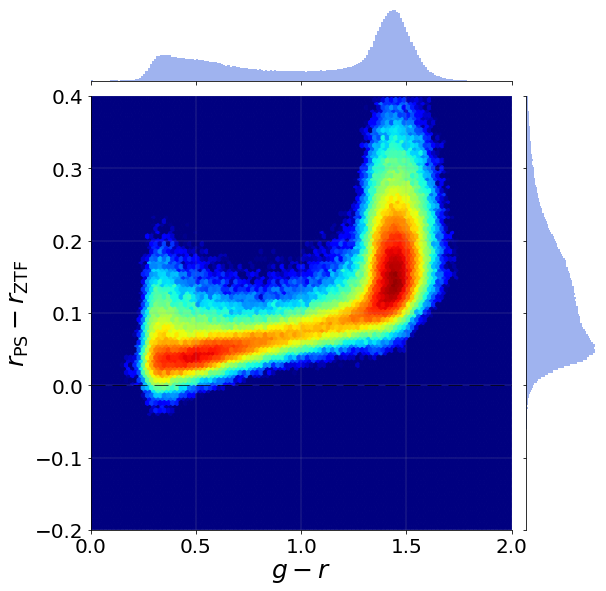

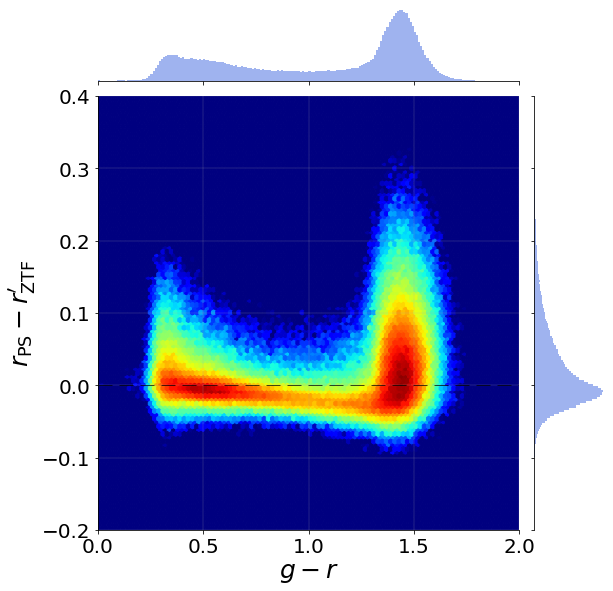

In [19]:
save = True
for color in ['mean_ri','mean_gr']:
    for survey1, survey2 in [('ps','sdss'),('ps','ztf')]:
#     color = 'mean_ri'
#     survey1 = 'ps'
#     survey2 = 'ztf'
        g = star_r.sns_correlate(color, survey1+'-'+survey2+'_nat', 1.5e1, 1e3, limits=[(0,2),(-0.2,0.4)], colorscale='log', xlabel=r'$'+color[-2]+'-'+color[-1]+'$', ylabel=r'$r_\mathrm{'+survey1.upper()+'}-r_\mathrm{'+survey2.upper()+'}$', save=save)
        g = star_r.sns_correlate(color, survey1+'-'+survey2       , 1.5e1, 1e3, limits=[(0,2),(-0.2,0.4)], colorscale='log', xlabel=r'$'+color[-2]+'-'+color[-1]+'$', ylabel=r'$r_\mathrm{'+survey1.upper()+'}-r_\mathrm{'+survey2.upper()+'}^\prime$', save=save)



# QSOS
---

In [20]:
qsos_r = calib('qsos','uid','r')
qsos_r.read()
qsos_r.join_colors()
qsos_r.calculate_offsets()

In [21]:
qsos_r.offsets['ps-sdss_nat'].mean()

-0.019124255730906443

In [22]:
qsos_r.offsets['ps-sdss'].mean()

-0.018599930382986178

In [23]:
qsos_r.offsets['ps-ztf_nat'].mean()

0.10921847439750976

In [24]:
qsos_r.offsets['ps-ztf'].mean()

0.08625492310383444

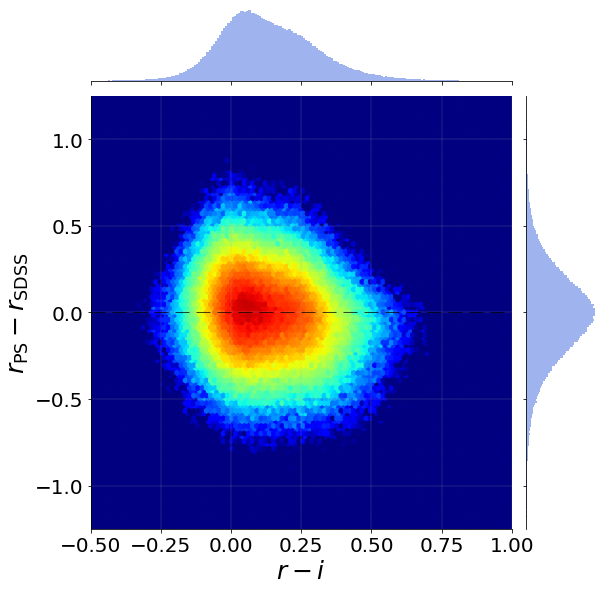

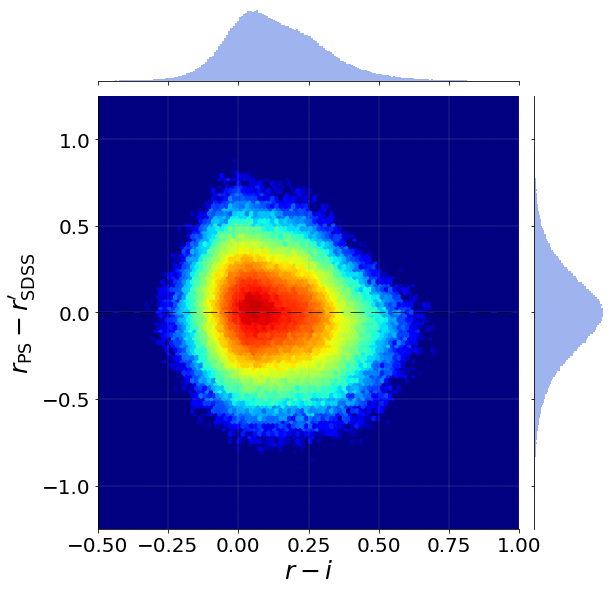

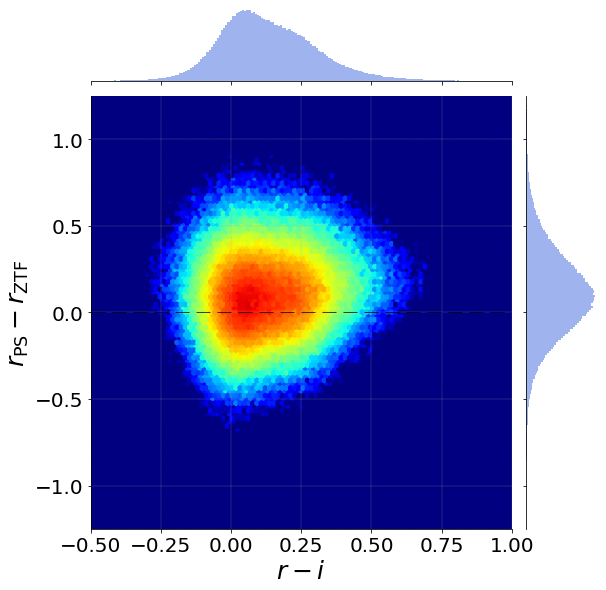

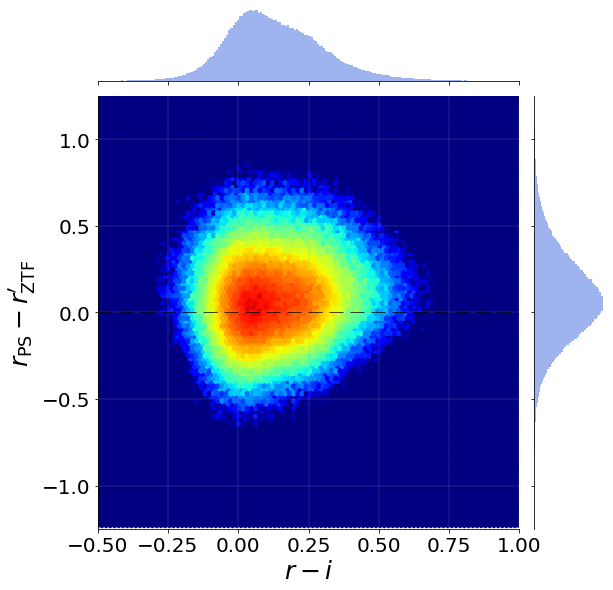

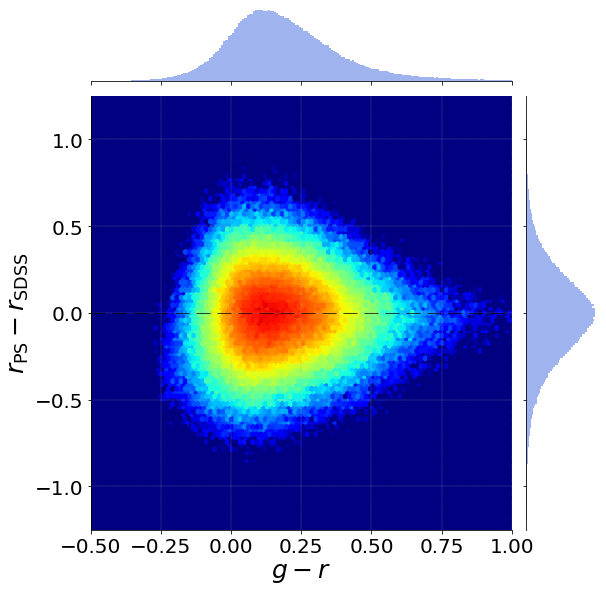

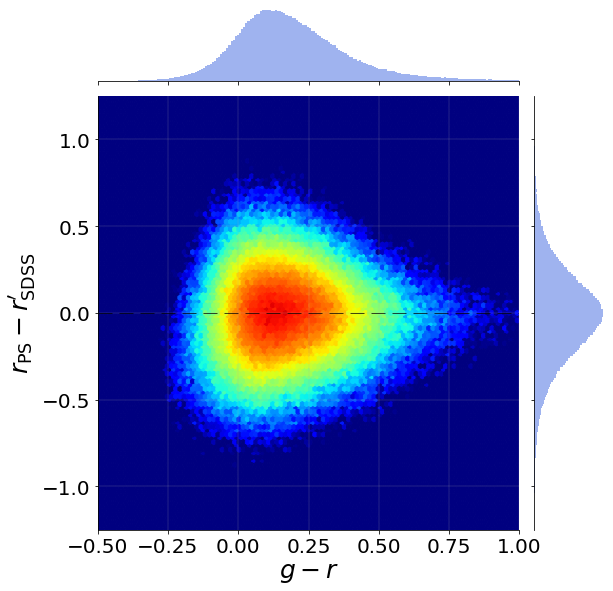

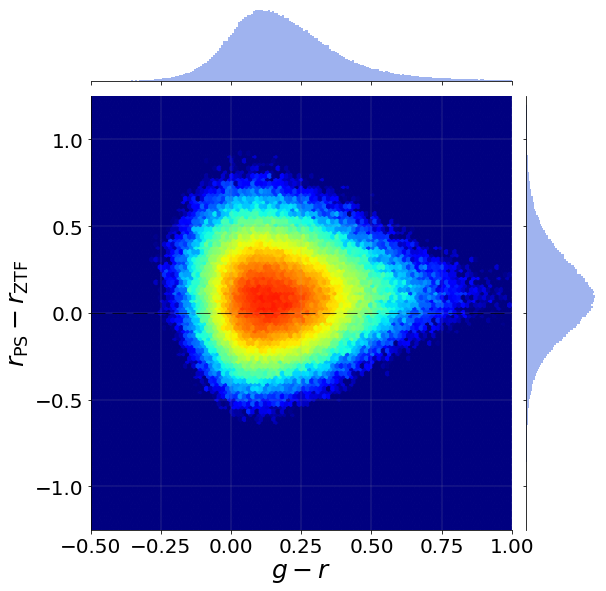

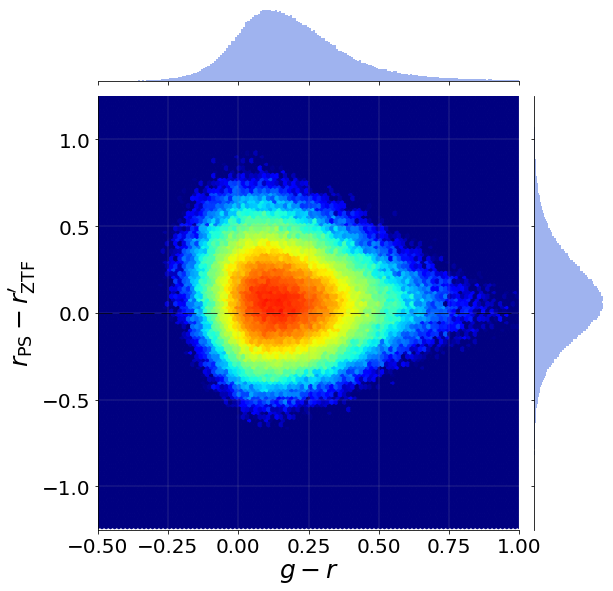

In [25]:
save = True
for color in ['mean_ri','mean_gr']:
    for survey1, survey2 in [('ps','sdss'),('ps','ztf')]:
#     color = 'mean_ri'
#     survey1 = 'ps'
#     survey2 = 'ztf'
        g = qsos_r.sns_correlate(color, survey1+'-'+survey2+'_nat', 1.5e1, 1e3, limits=[(-0.5,1),(-1.25,1.25)], colorscale='log', xlabel=r'$'+color[-2]+'-'+color[-1]+'$', ylabel=r'$r_\mathrm{'+survey1.upper()+'}-r_\mathrm{'+survey2.upper()+'}$', save=save)
        g = qsos_r.sns_correlate(color, survey1+'-'+survey2       , 1.5e1, 1e3, limits=[(-0.5,1),(-1.25,1.25)], colorscale='log', xlabel=r'$'+color[-2]+'-'+color[-1]+'$', ylabel=r'$r_\mathrm{'+survey1.upper()+'}-r_\mathrm{'+survey2.upper()+'}^\prime$', save=save)



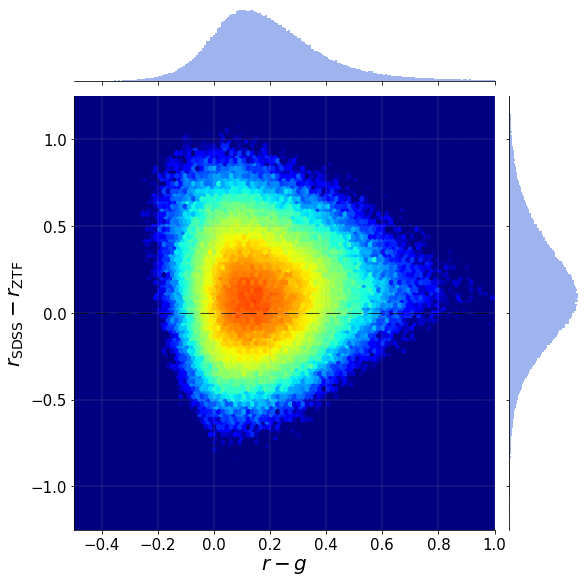

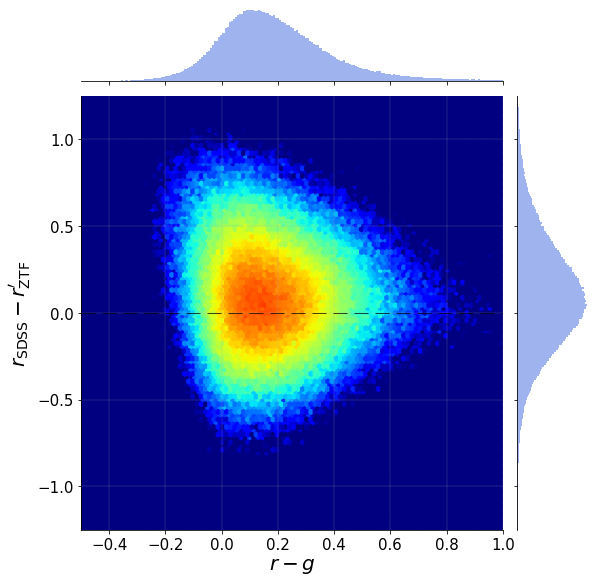

In [31]:
color = 'mean_gr'
survey1 = 'sdss'
survey2 = 'ztf'
g = qsos_r.sns_correlate(color, survey1+'-'+survey2+'_nat', 1.5e1, 1e3, limits=[(-0.5,1),(-1.25,1.25)], colorscale='log', xlabel=r'$'+color[-2]+'-'+color[-1]+'$', ylabel=r'$r_\mathrm{'+survey1.upper()+'}-r_\mathrm{'+survey2.upper()+'}$', save=True)
g = qsos_r.sns_correlate(color, survey1+'-'+survey2       , 1.5e1, 1e3, limits=[(-0.5,1),(-1.25,1.25)], colorscale='log', xlabel=r'$'+color[-2]+'-'+color[-1]+'$', ylabel=r'$r_\mathrm{'+survey1.upper()+'}-r_\mathrm{'+survey2.upper()+'}^\prime$', save=True)